**Introduction**

> This model demonstrates basic text classification starting from plain text files stored on disk. The model is trained to perform sentiment analysis on an IMDB dataset of movie reviews. This is an example of binary classification as it classifies movie reviews as either positive or negative.



> For this exercise, I'll use tensorflow 'layers' and 'losses' modules to build a neural network to classify movie reviews. The tensorflow layers.TextVectorization function will convert the input text to vectors, and, a simple neural network will generate probabilities for which sentiment applies to each text string. The neural network includes Embedding, Dropout, GlobalAveragePooling1D, and Dense layers. The 're' and 'string' modules will enable basic string operations, and the 'os' and 'shutil' modules support operating systrem and high-level file and directory handling. 



**1. Setup**

In [ ]:
import matplotlib.pyplot as plt
import os #(enables operating system dependent functionality)
import shutil #(for high-level file and directory handling)
import re #(this is the regular expression module)
import string #(for common string operations)
import tensorflow as tf #(tensorflow core v 2.7)

from tensorflow.keras import layers #(takes ina tensor and outputs a tensor)
from tensorflow.keras import losses #(used to compute the crossentropy loss between actual and predicted values)

In [ ]:
print(tf.__version__)

2.7.0


**2. Pre-process Data**

  > **a) Download data from url**



> The Large Movie Review Dataset contains 50,000 movie reviews from the Internet Movie Database. These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews.





> The "tf.keras.utils.get_file" method is used to download the dataset directly from the url. Default arguments per documkentation are tf.keras.utils.get_file (fname=None, origin=None, untar=False, md5_hash=None, file_hash=None, cache_subdir='datasets', hash_algorithm='auto', extract=False, archive_format='auto', cache_dir=None). The "untar" argument is a boolean, whether the file should be decompressed or not. In this case it needs to be decompressed because the source file ends in ".tar.gz".

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz" 
dataset =  tf.keras.utils.get_file("aclImdb_v1", url, untar=True, cache_dir='.', cache_subdir='')


> **b) Identify directory and file structure**

In [ ]:
os.path.dirname(dataset)

'.'

In [ ]:
os.listdir('./')

['.config', 'aclImdb_v1.tar.gz', 'aclImdb', 'drive', 'sample_data']

In [ ]:
os.listdir('./aclImdb/')

['test', 'README', 'imdb.vocab', 'imdbEr.txt', 'train']

In [ ]:
os.listdir('./aclImdb/train/')

['urls_neg.txt',
 'pos',
 'urls_unsup.txt',
 'urls_pos.txt',
 'unsupBow.feat',
 'labeledBow.feat',
 'neg',
 'unsup']

In [ ]:
os.listdir('./aclImdb/test/')

['urls_neg.txt', 'pos', 'urls_pos.txt', 'labeledBow.feat', 'neg']

> **c) Examine sample files**

In [ ]:
os.listdir('./aclImdb/train/pos')[:5]

['2248_7.txt', '6990_8.txt', '10597_9.txt', '7204_8.txt', '11733_10.txt']

In [ ]:
sample_file = os.path.join('./aclImdb/train/', 'pos/7204_8.txt')
with open(sample_file) as f:
  print(f.read())

If you are looking for a sonic-boom-special-effects monster, click the BACK button on your browser.<br /><br />Deathtrap was written by Ira Levin (Sliver, The Stepford Wives, Rosemary's Baby). It's a stage play, adapted for the screen. 95% of the movie takes place in the gorgeous home of playwright Sidney Bruhl (Michael Caine). He's the author of a fabulously successful Broadway play, but his last 4 efforts have flopped - horribly.<br /><br />An aspiring playwright, Clifford Anderson (Christopher Reeve), who attended a play-writing workshop given by Sydney, has sent him a copy of the play he has written. Sydney tells his wife, Myra (Dyan Cannon) the play is fabulous - a sure-fire hit. But is it good enough to die for? Time will tell.<br /><br />Clever dialog and numerous twists and turns in the plot keep this movie entertaining from beginning to end. The whole cast seems to have a good time. It's reminiscent of another fun Michael Caine mystery: Sleuth. Worth watching.<br /><br />


In [ ]:
os.listdir('./aclImdb/test/pos')[:5]

['6990_8.txt', '11257_10.txt', '11733_10.txt', '4341_7.txt', '8705_10.txt']

In [ ]:
sample_file2 = os.path.join('./aclImdb/test/', 'pos/4341_7.txt')
with open(sample_file2) as f:
    print(f.read())


LOL.<br /><br />The mere fact that I start off my review with 'lol' says it all. I used to watch this movie all the time as a kid; and even then I sensed the silliness of it all. The low budget, horrible acting and lame script was ever apparent back then. I watched it again yesterday and just couldn't stop laughing. It's so bad it's actually good lol. Like another reviewer said, it doesn't take itself seriously. There's no way one could look at this movie and say that the makers did so. The soundtrack is so funny, I laugh every time I hear it. The 'climax' is just a laugh riot. It's an all out war zone in New York, full of explosions and total chaos...so ridiculous you can't help but chuckle at the sight of it. <br /><br />Other hilarious moments: <br /><br />- The scene with Kersey and the cop running side by side like 2 cowboys against the whole Wild West was so cheesy it was funny.<br /><br />-It killed me how the bad guys could be shooting at Kersey and he could even drop down on o

> **d) Establish training, validation & test data splits**



> To prepare a dataset for binary classification, you will need two folders corresponding to class_a and class_b. These will be the positive and 
negative movie reviews, which can be found in aclImdb/train/pos and aclImdb/train/neg. Since the dataset contains additional folders, it is best to remove them beforehand. 

In [ ]:
shutil.rmtree('./aclImdb/train/unsup')

In [ ]:
os.listdir('./aclImdb/train/')

['urls_neg.txt',
 'pos',
 'urls_unsup.txt',
 'urls_pos.txt',
 'unsupBow.feat',
 'labeledBow.feat',
 'neg']



> The next step is to preparer the data for training. The tf.keras.text_dataset_from_directory utility is utilized. The default arguments are tf.keras.utils.text_dataset_from_directory(directory, labels='inferred', label_mode='int', class_names=None, batch_size=32, max_length=None, shuffle=True, seed=None, validation_split=None, subset=None, follow_links=False). Part of this process is splitting the training data into training and validation splits. An 80:20 split is used here. Note that batch_size and seed are declared variables outside of the function call. There is a total of 25,000
text files in the train folder. Some positive and some negative. The below command takes all 25,000 from both classes, pos and neg, shuffles them, reserves 20% for validation and returns the raw train dataset.

In [ ]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [ ]:
type(raw_train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset



> The tf.keras.utils.text_dataset_from_directory() method will return a tf.data.Dataset that yields batches of texts from the subdirectories class_a and class_b, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b). Only .txt files are supported at this time. Note, by default labels='inferred' and label_mode='int' in the method's parameters dictate this approach. It yields a tuple (texts, labels), where texts has shape (batch_size,) and labels follows the following format: if label_mode is int, the labels are an int32 tensor of shape (batch_size,). if label_mode is binary, the labels are a float32 tensor of 1s and 0s of shape (batch_size, 1). if label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index. So in this case, the dataset is a tuple of text and labels (texts, labels).

In [ ]:
for text_batch, label_batch in raw_train_ds.take(1): # The reviews contain raw text with punctuation and HTML tags, plus "b'" before each review.
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 



> Below we confirm the class names and associated integers. "0" means negative and "1" means positive.



In [ ]:
### Notice the reviews contain raw text (with punctuation and occasional HTML tags like <br/>). You will see how to handle these in the following section.
### The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the 'class_names' property on the dataset.

print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])


Label 0 corresponds to neg
Label 1 corresponds to pos


In [ ]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
for text_batch, label_batch in raw_val_ds.take(1): # The reviews contain raw text with punctuation and HTML tags, plus "b'" before each review.
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'a friend gave it to me saying it was another classic like "Debbie does Dallas". Nowhere close. I think my main complaint is about the most unattractive lead actress in porn industry ever. Even more terrible is that she is on screen virtually all the time. But I read somewhere that back in those days, porn had to have some "artistic" value. I was unable to find it though. See it only if you are interested in history of development of porn into mainstream, or can appreciate art in porn movies. I know I am not. But the director of the movie appears to be a talented person. He even tried to get Simon & Garfunkel to give him permissions to use his songs. Of course, they rejected.'
Label 0
Review b"The scenes are fast-paced. the characters are great. I love Anne-Marie Johnson's acting. I really like the ending. <br /><br />However, I was disappointed that this movie didn't delve deeper into Achilles's and Athena's relationship. It only blossomed when they kissed each other."
Label 1

In [ ]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)


Found 25000 files belonging to 2 classes.


In [ ]:
for text_batch, label_batch in raw_test_ds.take(1): # The reviews contain raw text with punctuation and HTML tags, plus "b'" before each review.
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'I only rented this stinker because of its relatively high ratings. It totally sucked! I cannot imagine how anyone would think this a good movie - even an OK movie. None of the characters had ANY redeeming qualities of any kind. To varying degrees they were each selfish and mean-spirited - or abused and damaged personalities who hadn\'t a clue about the spirit of Christmas (when this takes place!) I know Canadians and like them - but I cannot think that even THEY would think this a good movie. I\'d rather a sharp stick in the eye than watch this offensive movie again. A colossal waste of time and money. Do not believe the person who wrote the opinion that it was "worth watching." This person probably would enjoy having a dentist drill their teeth without anesthesia, too. Don\'t mean to be unkind but for the life of me I cannot imagine what this person was thinking. Unless they had ulterior motives. Maybe s/he was the director or the producer. If so, I\'d like to ask them to giv

> **e) Standardize, tokenize, and vectorize data for training**



> The tf.keras tf.keras.layers.TextVectorization layer method is used to standardize, tokenize, and vectorize the data before modeling. Standardization includes removing punctuation and/or HTML elements, for example, to simplify the dataset. Tokenization splits strings into tokens (for example, splitting a sentence into individual words by splitting on whitespace). Vectorization refers to converting tokens into numbers/arrays so they can be fed into a neural network. The default arguments are tf.keras.layers.TextVectorization(max_tokens=None, standardize='lower_and_strip_punctuation', split='whitespace', ngrams=None, output_mode='int', output_sequence_length=None, pad_to_max_tokens=False, vocabulary=None, idf_weights=None, sparse=False, ragged=False, **kwargs).



> Note: To prevent training-testing skew it is important to preprocess the data identically at train and test time. If this is a concern, the TextVectorization layer can be included directly inside the model.



> The TextVectorization layer which converts text to lowercase and strips punctuation by default, doesn't strip HTML characters. A custom standardization function is needed to do that. It includes making all text lowercase and pulling out some HTML code breaks ie ',br />'. regex_replace() just substitutes one value for another. string.punctuation = !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~. italicized text 



In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [ ]:
test_sentence = "This is a tests... % s to see %s how the commands *&^%$#@! work with 34% ?"
test1 = tf.strings.regex_replace(test_sentence, 'see', 'seedoo')
test2 = tf.strings.regex_replace(test_sentence, '[%s]' % re.escape(string.punctuation), '')
print(test1)
print(test2)

tf.Tensor(b'This is a tests... % s to seedoo %s how the commands *&^%$#@! work with 34% ?', shape=(), dtype=string)
tf.Tensor(b'This is a tests  s to see s how the commands  work with 34 ', shape=(), dtype=string)




> To create a all-encompassing text vectorization function, the TextVectorization layer is now used. This will standardize, tokenize, and vectorize our data. This will utilize the the custom standardization function you defined above. max_features and sequence_length are established here as global variables. Note that all sequences will now be 250 or less in length.

In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)


In [ ]:
type(vectorize_layer)

keras.layers.preprocessing.text_vectorization.TextVectorization



> Next, the adapt method is called to fit the state of the preprocessing layer to the dataset. Some preprocessing layers have an internal state that can be computed based on a sample of the training data. The list of stateful preprocessing layers is: 1) TextVectorization - holds a mapping between string tokens and integer indices; 2) StringLookup and IntegerLookup - holds a mapping between input values and integer indices; 3) Normalization - holds the mean and standard deviation of the features; and 4) Discretization - holds information about value bucket boundaries. These layers are non-trainable. Their state is not set during training. It must be set before training, either by initializing them from a precomputed constant, or by "adapting" them on data. You set the state of a preprocessing layer by exposing it to training data, via the adapt() method as shown here. Below the map function is used to remove the labels before utilizing the adapt function.

In [ ]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)



> The below 'vectorize_text' function will allow us to see the result of the TextVectorization layer in action.

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       



> The array shape for the vectorized tex is (1, 250). 250 is the mex sequence length established earlier. Note: the last three numbers are zeros, which indicates they are padding. Also, each number in the array correspnds to a word. You can lookup the token (string or word) that each integer corresponds to by calling .get_vocabulary() on the layer. The vocabulary size corresponds to the maximum number of features set earlier (10,000).

In [ ]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000




> To apply the vectorize_text function to the raw training data, as well as the test data, the .map function is used.

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [ ]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.MapDataset



> To view an item in thess objects, using an iterator is a good approach. Each iteration, as shown, is a 32x250 numpy array. 32 is the batch size. 250 is the maximum sequence length or the maximum length of a review allowed.

In [ ]:
iterator = train_ds.__iter__()
next = iterator.get_next()
example = next[0]
print(example.numpy())

[[   1    7    4 ...    0    0    0]
 [1354    2   61 ...    0    0    0]
 [  53  147    9 ...    0    0    0]
 ...
 [   2  435    5 ...    0    0    0]
 [   2 3137   65 ...    0    0    0]
 [1518 5282 1659 ...    0    0    0]]


In [ ]:
example.numpy().shape


(32, 250)

> **f) Configure the dataset for performance**

> To make sure that I/O does not end up blocking when loading data and to maximize performance, use .cache() and .prefectch(). .cache() keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files. .prefetch() overlaps data preprocessing and model execution while training. AUTOTUNE tunes the buffer value dynamically and is set here as a global variable.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

**3. Create the Model**

> The model is a simple neural network made up of one Embedding layer, one GlobalAveragePooling1D layer, two dropout layers and 1 Dense layer. The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings).
The default arguments are tf.keras.layers.Embedding(input_dim, output_dim, embeddings_initializer='uniform', embeddings_regularizer=None, activity_regularizer=None, embeddings_constraint=None, mask_zero=False, input_length=None, kwargs). The GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. The output has one dimension in this case. This allows the model to handle input of variable length, in the simplest way possible. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged. Note that the Dropout layer only applies when training is set to True such that no values are dropped during inference. The default arguments are tf.keras.layers.Dropout(rate, noise_shape=None, seed=None, kwargs). Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True).

In [ ]:
embedding_dim = 16 # this creates a global variable for the embedding dimension

In [ ]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),   # (32,250,16)
  layers.Dropout(0.2),                                 # (32,250,16)  
  layers.GlobalAveragePooling1D(),                     # (32, 16)
  layers.Dropout(0.2),                                 # (32, 16)
  layers.Dense(1)])                                    # (32,1)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

**4. Compile Model**

> Once the model is created, you can config the model with losses, an optimizer and metrics model.compile(). The default arguments are model.compile(optimizer='rmsprop', loss=None, metrics=None, loss_weights=None, weighted_metrics=None, run_eagerly=None, steps_per_execution=None, **kwargs). It is necessary to name a loss function and an optimizer for training. We want the model to output a probability (a single-unit layer with a sigmoid activation). The losses.BinaryCrossentropy loss function is appropriate for this. The default arguments are tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.0, axis=-1, reduction=losses_utils.ReductionV2.AUTO, name='binary_crossentropy'). The optimizer chosen here is 'adam'. For metrics, we use the tf.metrics.BinaryAccuracy method. The default arguments are tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5).

In [ ]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

**5. Train the Model**

>  Train the model with tf.keras.model.fit(). To do so you will passing the dataset object to the fit method. Here we can also name the validation dataset and set the number of training epochs.

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 13s 20ms/step - loss: 0.6653 - binary_accuracy: 0.6901 - val_loss: 0.6175 - val_binary_accuracy: 0.7746
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.5517 - binary_accuracy: 0.8000 - val_loss: 0.5010 - val_binary_accuracy: 0.8206
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4471 - binary_accuracy: 0.8423 - val_loss: 0.4220 - val_binary_accuracy: 0.8458
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3794 - binary_accuracy: 0.8647 - val_loss: 0.3750 - val_binary_accuracy: 0.8604
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3372 - binary_accuracy: 0.8791 - val_loss: 0.3462 - val_binary_accuracy: 0.8672
Epoch 6/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3063 - binary_accuracy: 0.8874 - val_loss: 0.3270 - val_binary_accuracy: 0.8720
Epoch 7/10
625/625 [==============================] - 5s 8ms/s

**6. Evaluate the Model**

> model.evaluate() can be used to assess model performance on the test dataset. The default arguments are model.evaluate(x=None, y=None, batch_size=None, verbose=1, sample_weight=None, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, return_dict=False, **kwargs). Two values will be returned: Loss (which represents the magnitude of error) and accuracy (a percentage).

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 9s 12ms/step - loss: 0.3100 - binary_accuracy: 0.8737
Loss:  0.3100051283836365
Accuracy:  0.8737199902534485


> model.fit() returns a History object that contains a dictionary with everything that happened during training. We can use this data to create a graph of loss and accuracy. There are four entries: one for each monitored metric during training and validation.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

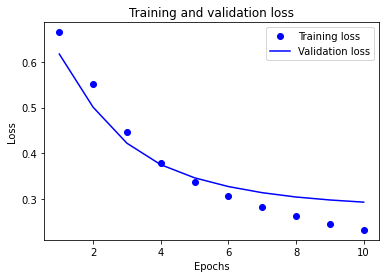

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss') # "bo" is for "blue dot"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b is for "solid blue line"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

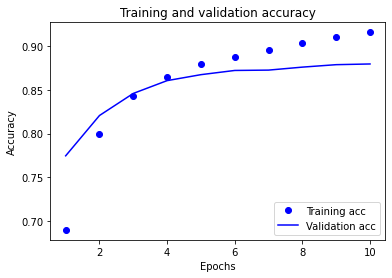

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

**7. Export the Model**

> In the code above, the TextVectorization layer was applied to the dataset before feeding text to the model. To make the model capable of processing raw strings (for example, to simplify deploying it), add the TextVectorization layer to your model. To do so, it is easiest to use the weights that were just trained.

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)


> Below the exported model is tested on raw strings from the dataset.

In [ ]:
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 10s 12ms/step - loss: 0.3100 - accuracy: 0.8737
0.8737199902534485


> Inference on new data. To get predictions for new examples, call model.predict() on the new text. The default arguments for model.predict() are model.predict(x, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)

In [ ]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.63984054],
       [0.46747077],
       [0.382709  ]], dtype=float32)

> The predictions are probabilities. Rounding 0.5 and higher up to 1, or less than 0.5 down to 0 yields the appropriate labels. This suggests the first review is positive (rounds to 1) and the next two are negative (rounds to zero).

**8. Final Comments**



> The model classified movie reviews with 87% accuracy after 10 epochs of training. Adding additional layers from the list of those already being used didn't improve performance. Instead it led to overfitting of the training data. This is an example where a simple model is quite powerrful without enhancement.

